# <center/> Project 3: Spacecraft segmentation

**Case Description**: build a model to predict spacecraft trajectory in order to avoid their collision with space debris.

**Task**: Semantic Segmentation of spacecraft components.

**Metrics**: to achieve mIoU > 0.70 on the validation sample.

**Data**: SatelliteDataset by [link](https://github.com/Yurushia1998/SatelliteDataset)

# 0. Install and Import

In [1]:
%matplotlib inline

# import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from datetime import datetime

# Libs to work with image
import cv2
import albumentations as A

# PyTorch libs
import torch
# import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F_torch

In [2]:
"""
Set random seeds

Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if installed).
Args:
    seed (:obj:`int`): The seed to set
"""
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed()

In [3]:
# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

In [4]:
# Check available device
print(torch.cuda.is_available())

# Device name
print(torch.cuda.get_device_name(0))

True
Tesla T4


# 1. Data Loading: dataset exploration

The first step in any ML or DL tasks is create dataset for further work.

Images are the key element for Computer Vision project.

Let's check dataset structure

In [5]:
# Define path to our data
DATA_DIR = Path('/kaggle/input/project-3-dataset/Final_dataset')
WORKING_PATH = Path('/kaggle/working')
RESULTS = Path('/kaggle/input/spacecraft-component-segmentation')

In [6]:
!ls {DATA_DIR}/*.txt
!tree -d {DATA_DIR}

/kaggle/input/project-3-dataset/Final_dataset/ReadMe.txt
/kaggle/input/project-3-dataset/Final_dataset/all_bbox.txt
/kaggle/input/project-3-dataset/Final_dataset
|-- images
|   |-- train
|   `-- val
`-- mask
    |-- train
    `-- val

6 directories


`Our data already divided into train and val folders.`

At the next step we need to preparing data for model

# 2. Model: Semantic Segmentation

# 2.1. Preparing data for model

There are 4 classes:
- background,
- solar panels,
- spacecraft,
- antennas**.

For further work, we need to create an encoded class with labels and an array with colors corresponding to the labels. There are only three colors in total, one color per class:
- **red (solar panel)**,
- **green (satellite)**
- **blue (antenna)**.
- the fourth class is the absence of color, **black**. It is represented by the **background class**.

In [7]:
# Create checkout labels and a corresponding array of color-coded classes. 
class_names = ['background', 'solar_panel', 'satellite', 'antenna']
class_rgb = [[0,0,0], [255,0,0], [0,255,0], [0,0,255]]
class_labels = [0, 1, 2, 3]
rgb_vals = np.array(class_rgb)[class_labels]

print(f" Class: {class_names[0]}, Label: {class_labels[0]}, Color black: {rgb_vals[0]}")
print(f" Class: {class_names[1]}, Label: {class_labels[1]}, Color red: {rgb_vals[1]}")
print(f" Class: {class_names[2]}, Label: {class_labels[2]}, Color green: {rgb_vals[2]}")
print(f" Class: {class_names[3]}, Label: {class_labels[3]}, Color green: {rgb_vals[3]}")

 Class: background, Label: 0, Color black: [0 0 0]
 Class: solar_panel, Label: 1, Color red: [255   0   0]
 Class: satellite, Label: 2, Color green: [  0 255   0]
 Class: antenna, Label: 3, Color green: [  0   0 255]


In [8]:
"""
Declare auxiliary functions
"""

def encode(label, label_values):
    """
    Encoding function
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    
    Returns
    A 2D array with the same width and hieght as the input, but
    with a depth size of num_classes
    """
    semantic_map = []
    
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis =-1)
        semantic_map.append(class_map)
        
    x = np.stack(semantic_map, axis=-1)
    
    return x


def reverse(image):
    """
    Reverse encoding function
    
    Perform reverse one-hot-encoding on labels / preds
    """
    x = np.argmax(image, axis = -1)
    
    return x
        
        
def color_code(image, label_values):
    """
    Color coding function
    
    Perform colour coding on the reverse-one-hot outputs
    """
    clr_cod = np.array(label_values)
    x = clr_cod[image.astype(int)]
    
    return x


def show_img(a=0, **images):
    """
    Helper function for data visualization
    """
    plt.figure(figsize=(15,5))
    
    for idx, (name, image) in enumerate(images.items()):
        title_pict = list(images.keys())[0]
        img = images[title_pict]
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([]); plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace("_"," ").title(), fontsize=12)
        plt.imshow(image)
        plt.imshow(img, alpha=a)
        
    plt.show()

## Custom PyTorch Dataset
The original RGB masks are one-hot encoded to tensors of the [C, H, W] dimensions with four (C=4) channels: one background and three classes. Some images in the dataset are corrupted and cannot be read, also there are no masks for a number of images, therefore for these cases we skip to the next images using a try/except construction.

In [9]:
class SpacecraftDataset(Dataset):
    
    def __init__(self, transforms=None, class_rgb=None, preprocessing=None, split='train'):
        # Split into train and val sets
        if split == 'train':
            self.image_path = DATA_DIR/"images/train"
            self.mask_path = DATA_DIR/"mask/train"
        else:
            self.image_path = DATA_DIR/"images/val"
            self.mask_path = DATA_DIR/"mask/val"
                            
        self.image_filenames = sorted(self.image_path.glob("*.png"))       
        self.transform = transforms
        self.preprocessing = preprocessing
        self.class_rgb = class_rgb


    def __len__(self):
        return len(self.image_filenames)

    
    def __getitem__(self, idx):
        """
        Try/except construction is needed to skip to the next index for corrupted images or when a mask is absent
        """
        try: 
            # Reading in an image
            image_filename = self.image_filenames[idx]   
            image = cv2.imread(str(image_filename), cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                   
            # Reading in a mask
            mask_filename = (
                self.mask_path/
                    str(image_filename.name.split(".")[0] + '_mask.png'))
            
            if mask_filename.is_file():
                mask = cv2.imread(str(mask_filename), cv2.IMREAD_COLOR)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                
            else:
                # This exception is raised when a system function returns a system-related error,
                # including I/O failures such as “file not found” or “disk full”.
                raise(IOError)
            
            # Mask one-hot encoding: background + 3 classes
            mask = encode(mask, self.class_rgb).astype('float')
            
            # Transformations/augmentations
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image, mask = transformed['image'], transformed['mask']
            
            # Prprocessing.  
            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
                
#             mask = mask.permute(2, 0, 1)  # (H,W,C) -> (C,H,W)
            
            return image, mask
            
        except:
            # skip to the next index
            if idx + 1 <= self.__len__():
                return self.__getitem__(idx + 1)
            else:
                raise StopIteration

## Visualization of images, augmentations, and masks
Here are the functions that randomly display our images (with/without augmented for the training dataset and original for the validation). Notice that the images both feeded to the network and the inference are actually of the 520x520 size, but for visualization we restore their original format.

### Augmentations and transformations
Augmentation of the training dataset. We also resize the images to 528×528 px and normalize them with the default mean and std values, according to the recommendations for the PyTorch implementation of the DeepLabV3 model which is to be used further.

In [10]:
"""
Setting augmentation functions and parameters
"""
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomCropFromBorders(),
#     A.OneOf([
#         A.ColorJitter(hue=0.1),
#         A.Equalize(by_channels=False),
#         A.FancyPCA(),
#         A.GaussNoise(),
#         A.ImageCompression(),
#         A.RandomGamma(),
#         A.RandomToneCurve(),
#         A.AdvancedBlur(),
#     ]),
    A.Resize(528, 528),
    A.RandomRotate90(),
    A.Normalize()
    ])

valid_transform = A.Compose([
    A.Resize(528, 528),
    A.Normalize()
])


def to_tensor(x, **kwargs):
    """
    Tensor conversion function
    """
    return x.transpose(2, 0, 1).astype('float32')

 
def get_preprocessing(preprocessing_fn=None):
    """
    Transformation preprocessing function
    """
    _transform = []
    
    if preprocessing_fn:
        _transform.append(A.Lambda(image=preprocessing_fn))
        
    _transform.append(A.Lambda(image=to_tensor, mask=to_tensor))
    
    return A.Compose(_transform)

In [11]:
"""
Create dataset without augmentation
"""
no_aug_train_dataset = SpacecraftDataset(class_rgb=rgb_vals)
no_aug_valid_dataset = SpacecraftDataset(class_rgb=rgb_vals, split='val')

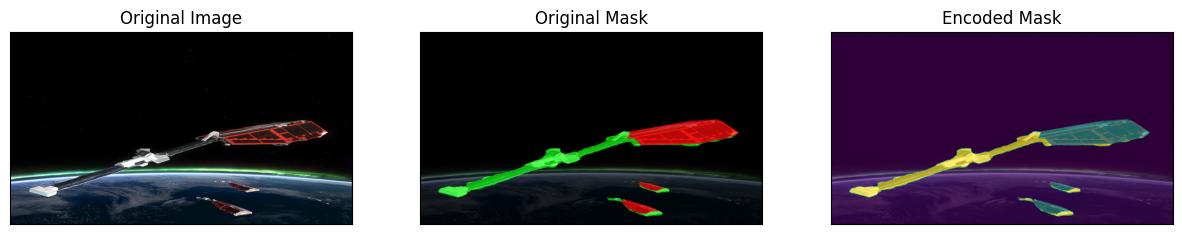

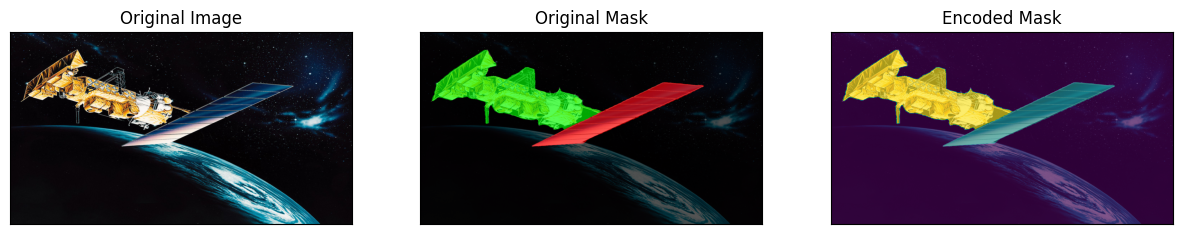

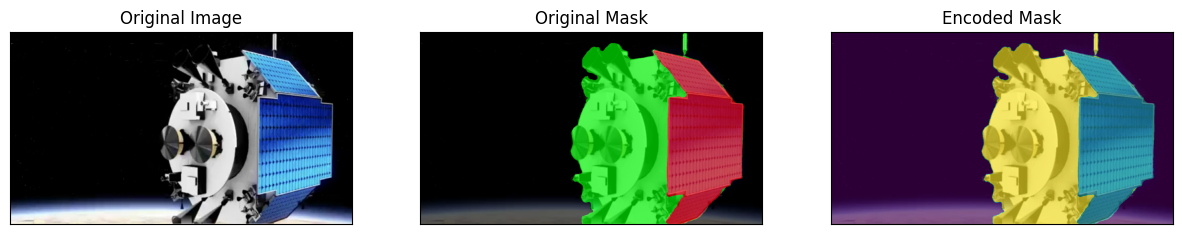

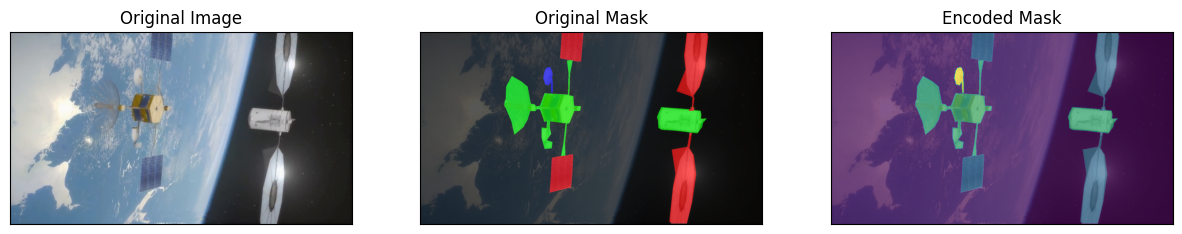

In [12]:
"""
Display four pictures on the screen.
The original image, its mask and the encoded One-Hot mask.
"""
for i in range(4):
    idx = random.randint(0, len(no_aug_train_dataset)-1)
    image, mask = no_aug_train_dataset[idx]
    
    show_img(0.35,
        original_image = image,
        original_mask = color_code(reverse(mask), rgb_vals),
        encoded_mask = reverse(mask))

`Transformed pictures and their masks.`

In [13]:
"""
Create dataset with augmentation
"""
aug_train_dataset = SpacecraftDataset(transforms=train_transform, class_rgb=rgb_vals)
aug_valid_dataset = SpacecraftDataset(transforms=valid_transform, class_rgb=rgb_vals, split='val')

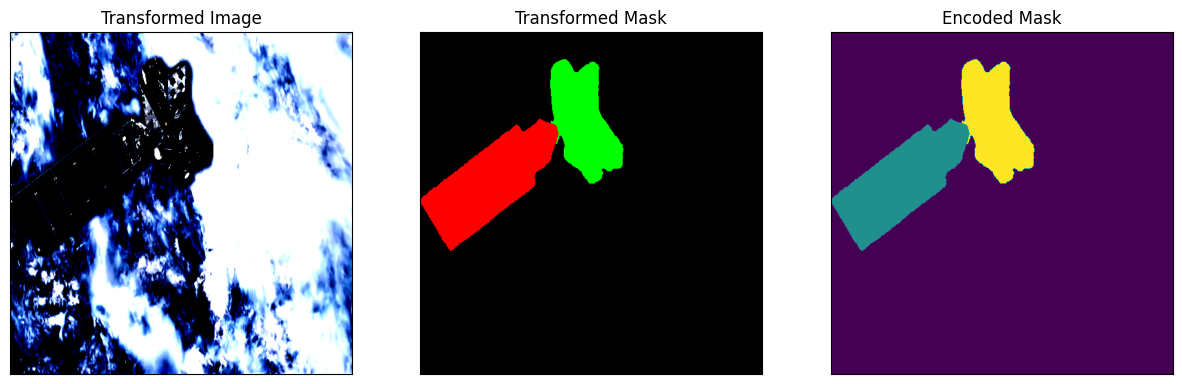

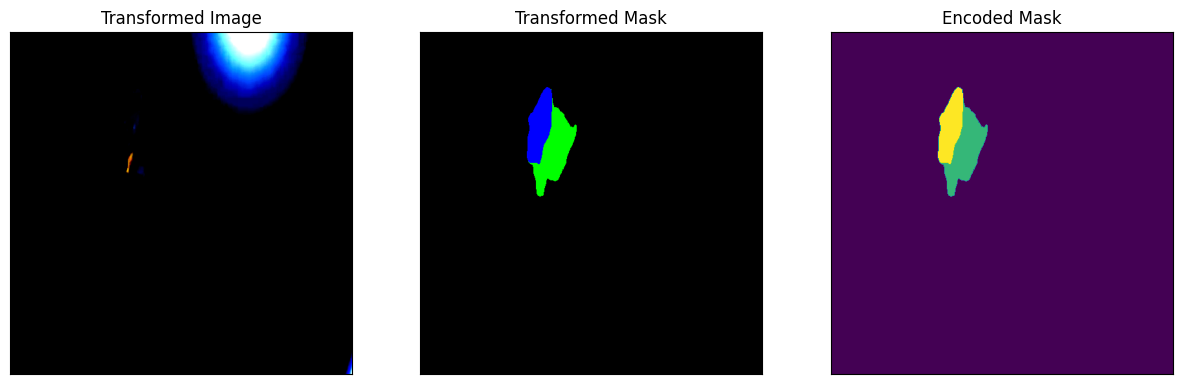

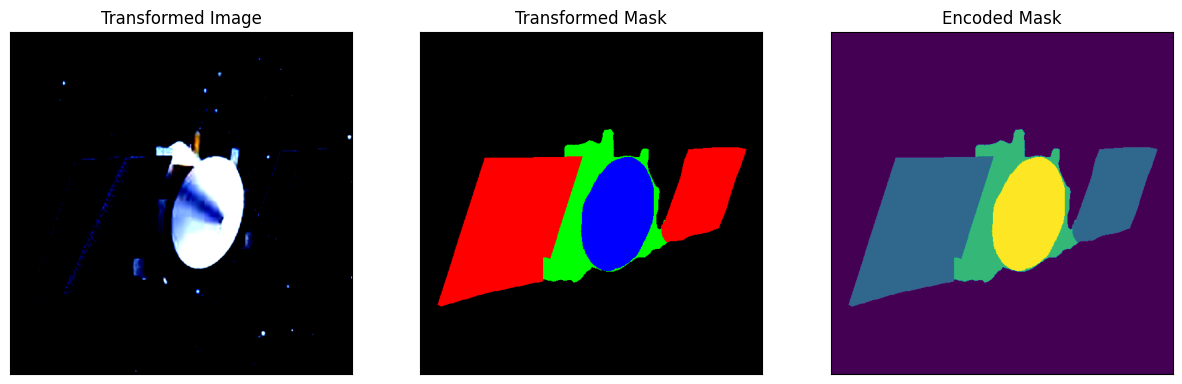

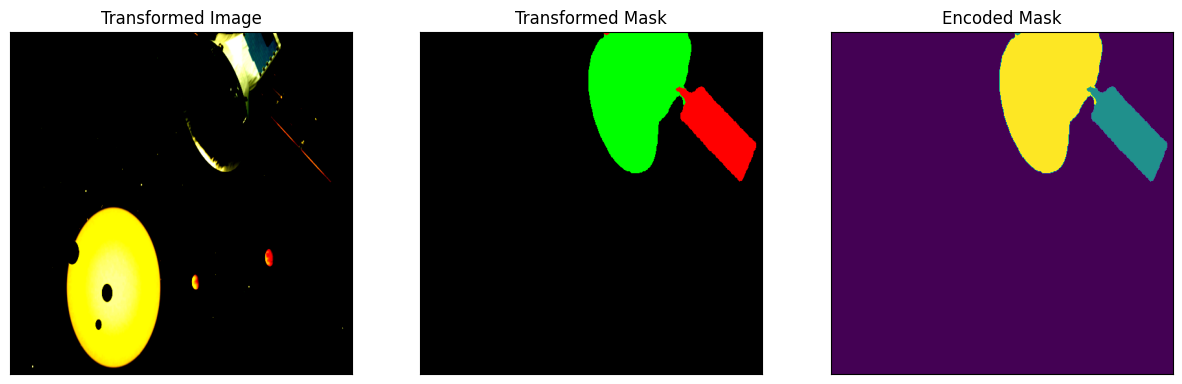

In [14]:
"""
Display four pictures on the screen.
The original image, its mask and the encoded One-Hot mask.
"""
for i in range(4):
    idx = random.randint(0, len(aug_train_dataset)-1)
    image, mask = aug_train_dataset[idx]
    
    show_img(
        transformed_image = image,
        transformed_mask = color_code(reverse(mask), rgb_vals),
        encoded_mask = reverse(mask))

# 2.2. Model

## DeepLabV3 model

We use the PyTorch implementation of the DeepLabV3+ on ResNet50 pretrained on ImageNet as the backbone model.

DeepLabv3+ is a semantic segmentation architecture that builds on DeepLabv3 by adding a simple yet effective decoder module to enhance segmentation results. It has the ability to pick up larger context information due to atrous convolutions and the ability to extract features at different scales. These factors make it extremely effective when dealing with images with objects of different sizes.

In [15]:
%%capture

try:
    import segmentation_models_pytorch as smp
except:
    print('The module segmentation_models_pytorch is being installed.')
    !pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
# clear_output(wait=False)
print('Version of installed segmentation_models_pytorch module:', smp.__version__)

In [16]:
model = smp.DeepLabV3Plus(encoder_name='resnet50', 
                          encoder_weights='imagenet',
                          classes=len(class_names),
                          activation='softmax2d')

preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet50', 'imagenet')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 247MB/s]


In [17]:
BATCH_SIZE = 16

# Datasets
train_dataset = SpacecraftDataset(
    transforms=train_transform,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb=rgb_vals)

valid_dataset = SpacecraftDataset(
    transforms=valid_transform,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb=rgb_vals,
    split='val')

# DataLoaders  
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=1, 
    shuffle=False)

In [18]:
# Checking if everything is OK with dataset readout:
for el in tqdm(train_dataset):
    pass

for el in tqdm(valid_dataset):
    pass

  0%|          | 0/2517 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2.3 Model Training

**Parameters**:
* DiceLoss - is a measure of overlap, generally used in image segmentation. The advantage of using dice loss is that it can very well handle the class imbalance in terms of pixel count for foreground and background.
* The optimizer is Adam. We also set the initial learning rate to vary at the beginning of the epochs according to the "cosine annealing with warm restarts" schedule.

In [20]:
loss = smp_utils.losses.DiceLoss()
metrics = [smp_utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.00008)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True)

In [21]:
%%time

EPOCHS = 5
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):
    start = datetime.now()
    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['iou_score']:
        best_iou_score = valid_logs['iou_score']
        torch.save(model, f'best_model.pth')
        print('Model saved!')

    end = datetime.now()
    print(f"Execution time of epoch {i}: {str(end-start)[:7]}")
    
log_train = pd.DataFrame(train_logs_list)
log_valid = pd.DataFrame(valid_logs_list)


Epoch: 0
valid: 100%|██████████| 600/600 [02:16<00:00,  4.39it/s, dice_loss - 0.4292, iou_score - 0.4895]
Model saved!
Execution time of epoch 0: 0:15:07

Epoch: 1
valid: 100%|██████████| 600/600 [02:16<00:00,  4.40it/s, dice_loss - 0.1904, iou_score - 0.7238]
Model saved!
Execution time of epoch 1: 0:15:05

Epoch: 2
valid: 100%|██████████| 600/600 [02:17<00:00,  4.37it/s, dice_loss - 0.1401, iou_score - 0.7857]
Model saved!
Execution time of epoch 2: 0:15:05

Epoch: 3
valid: 100%|██████████| 600/600 [02:16<00:00,  4.41it/s, dice_loss - 0.1452, iou_score - 0.7687]
Execution time of epoch 3: 0:15:03

Epoch: 4
valid: 100%|██████████| 600/600 [02:16<00:00,  4.40it/s, dice_loss - 0.08723, iou_score - 0.8589]
Model saved!
Execution time of epoch 4: 0:15:05
CPU times: user 1h 11min 4s, sys: 9min 46s, total: 1h 20min 51s
Wall time: 1h 15min 26s


***

# 3. Prediction (+ visualization)

### `Loading the best model obtained after training`

In [22]:
best_model = torch.load('best_model.pth', map_location=device)

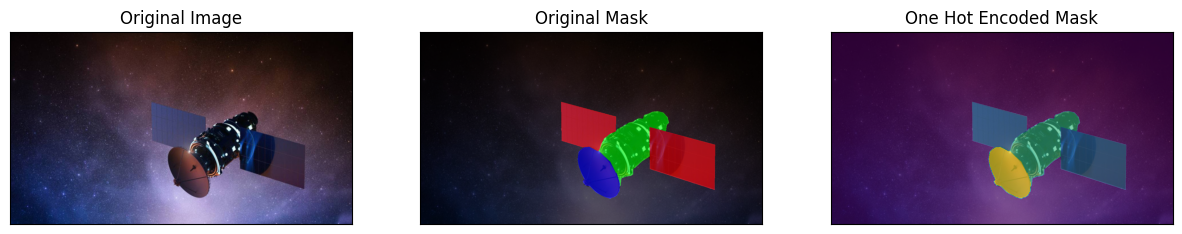

In [34]:
"""
Create datasets and Dataloader from which forecast pictures will be displayed and prediction quality metrics will be determined
"""
# Dataset for the tests.
test_dataset = SpacecraftDataset(
    transforms=valid_transform,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb=rgb_vals,
    split='val'
)

test_loader = DataLoader(test_dataset)

# Dataset for the pictures.  
test_pict_set = SpacecraftDataset(
    transforms=valid_transform,
    class_rgb=rgb_vals,
    split='val'
)

# Random selection of index and mask from test dataset.  
idx = random.randint(0, len(test_pict_set)-1)
image, mask = test_pict_set[idx]

show_img(0.4,
    original_image = image,
    original_mask = color_code(reverse(mask), rgb_vals),
    one_hot_encoded_mask = reverse(mask)
)

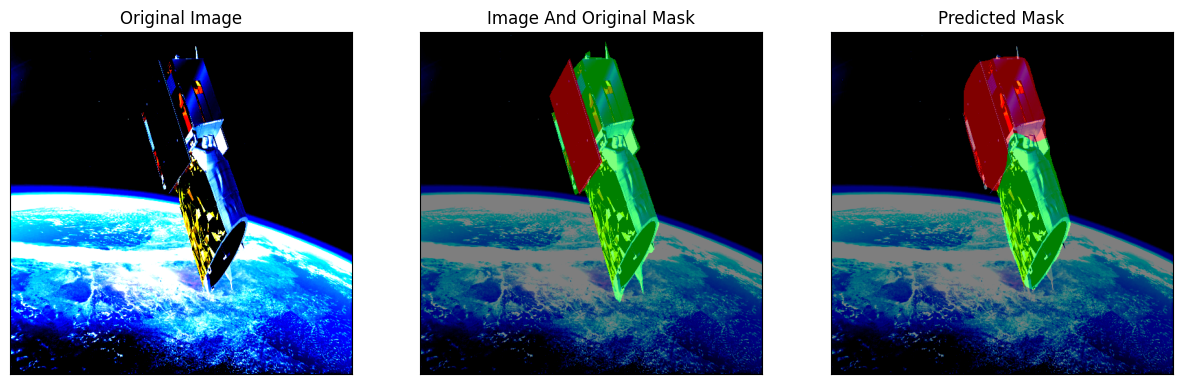

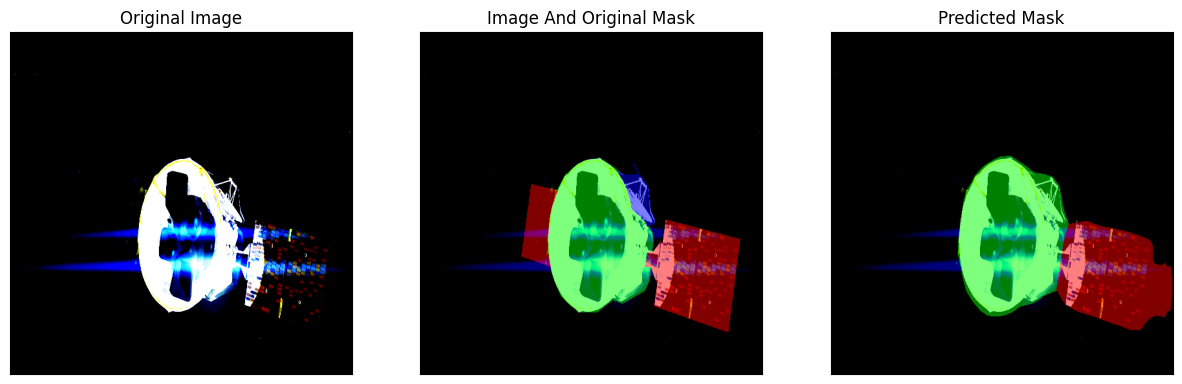

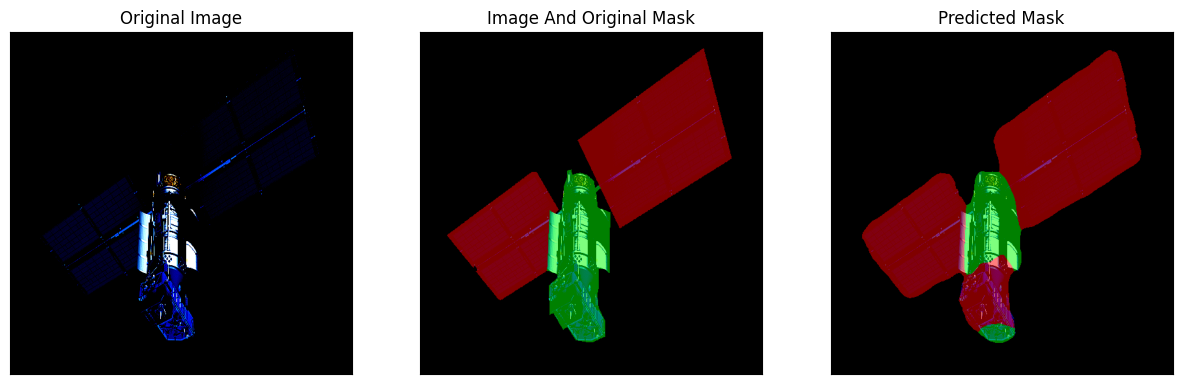

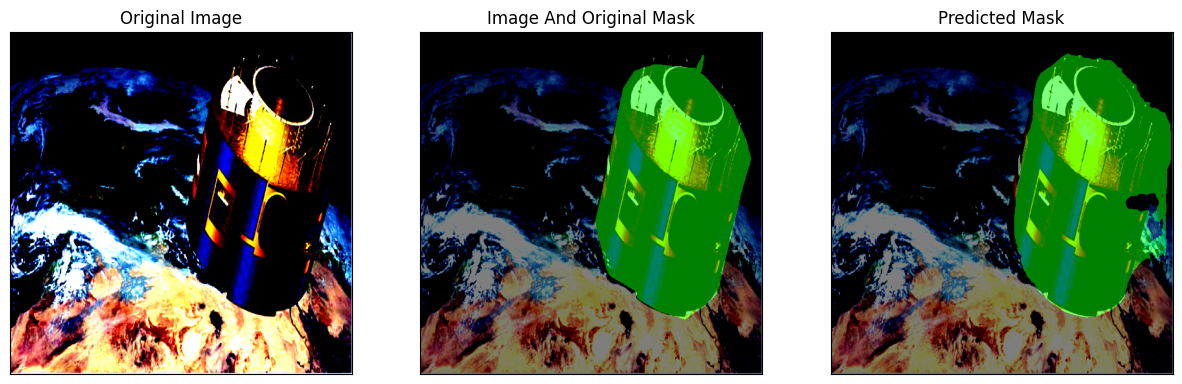

In [32]:
"""
Look at the predicted drawings with masks and compare them with the originals
"""
for idx in range(4):
    image, orig_mask = test_dataset[idx]
    image_pict = test_pict_set[idx][0]
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format    
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = color_code(reverse(pred_mask), rgb_vals)
    
    orig_mask = np.transpose(orig_mask,(1,2,0))
    orig_mask = color_code(reverse(orig_mask), rgb_vals)
    
    transform = T.Compose([T.Resize(size=(720,1280))])
#     image_pict = transform(F_torch.to_pil_image(image_pict.astype('uint8')))
#     orig_mask = transform(F_torch.to_pil_image(orig_mask.astype('uint8')))
#     pred_mask = transform(F_torch.to_pil_image(pred_mask.astype('uint8')))

    show_img(0.5,
        original_image = image_pict,
        image_and_original_mask = orig_mask,
        predicted_mask = pred_mask
    )

`We start evaluating the test data.`

In [33]:
test_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

valid_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 600/600 [02:16<00:00,  4.39it/s, dice_loss - 0.0873, iou_score - 0.8587] 
Evaluation on Test Data: 
Mean IoU Score: 0.8587
Mean Dice Loss: 0.0873


`Build metrics diagrams.`

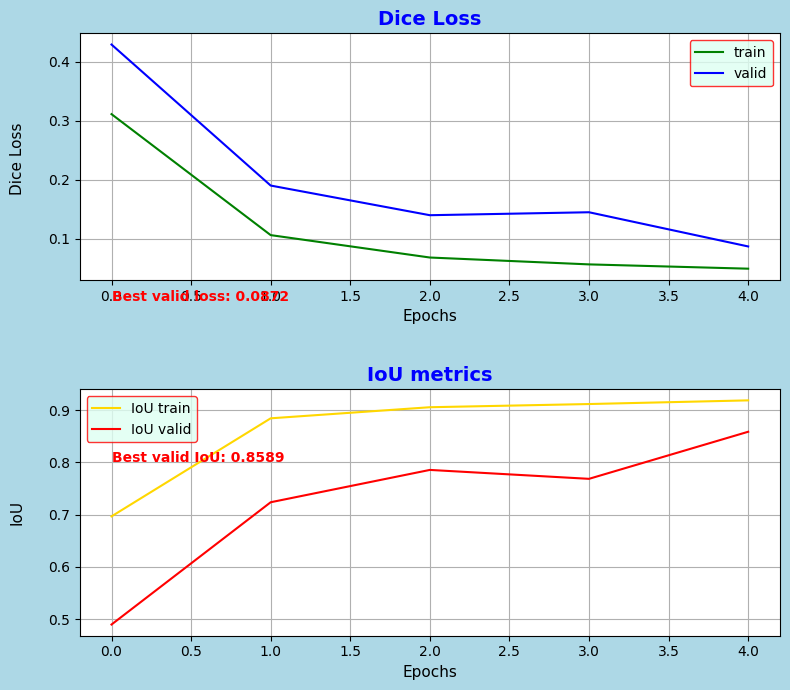

In [35]:
log_idx = log_train.index.to_list()
lt_dice, lv_dice = log_train.dice_loss.to_list(), log_valid.dice_loss.to_list()
lt_iou, lv_iou = log_train.iou_score.to_list(), log_valid.iou_score.to_list()

# Constructing a diagram
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,7), facecolor='lightblue')
ax1.plot(log_idx, lt_dice, marker='', label='train', c='g')
ax1.plot(log_idx, lv_dice, marker='', label='valid', c='b');
ax1.legend(loc='best',frameon=True, edgecolor='red', facecolor='#DEFFF2')
ax1.set_title(f'Dice Loss', fontsize=14, fontweight='bold', c="b")
ax1.set_xlabel('Epochs', fontsize=11)
ax1.set_ylabel('Dice Loss \n', fontsize=11)
ax1.text (log_idx[0], -0.005, f"Best valid loss: {round(np.min(lv_dice),4)}", fontweight='bold', c='r' )
ax1.grid(); 
ax2.plot(log_idx, lt_iou, marker='', label='IoU train', c='gold');
ax2.plot(log_idx, lv_iou, marker='', label='IoU valid', c='r');
ax2.legend(loc='best', frameon=True, edgecolor='red', facecolor='#DEFFF2')
ax2.set_title(f'IoU metrics', fontsize=14, fontweight='bold', c="b")
ax2.set_xlabel('Epochs', fontsize=11)
ax2.set_ylabel('IoU\n', fontsize=11)
ax2.text (log_idx[0], 0.8, f"Best valid IoU: {round(np.max(lv_iou),4)}", fontweight='bold', c='r' )
ax2.grid(); 
fig.tight_layout(h_pad=3)
plt.show();

## Conclusion
A model for semantic segmentation of spacecraft components (body, solar panels, antennas) has been constructed based on the DeepLabV3Plus model. An IOU metric of 0.85 has been achieved.